In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering


In [23]:
data = pd.read_csv("/content/mcdonalds.csv")

In [24]:
data.head()

yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   
3   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes        No      No   
4    No        Yes    No       Yes    Yes  Yes   Yes    No        No     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  
3        Yes   +4   69         Once a week  Female  
4         No   +2   49        Once a month    Male

In [35]:

MD_x = data.iloc[:, 0:11].values

# Convert "Yes" to 1 and "No" to 0
MD_x = (MD_x == "Yes").astype(int)

# Calculate the column means and round them to 2 decimal places
col_means = np.round(np.mean(MD_x, axis=0), 2)

# Display the column means
print(col_means)


[0. 0. 0. 0. 0.]


In [36]:
from sklearn.decomposition import PCA
# Perform PCA
pca = PCA()
MD_pca = pca.fit(MD_x)

# Get the explained variance
explained_variance = pca.explained_variance_ratio_

# Get the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Display the summary
print("Importance of components:")
print("Standard deviation:", np.sqrt(pca.explained_variance_))
print("Proportion of Variance:", np.round(explained_variance, 4))
print("Cumulative Proportion:", np.round(cumulative_explained_variance, 4))

Importance of components:
Standard deviation: [0. 0. 0. 0. 0.]
Proportion of Variance: [nan nan nan nan nan]
Cumulative Proportion: [nan nan nan nan nan]


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:545: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [39]:
# Get the standard deviations
standard_deviations = np.sqrt(pca.explained_variance_)

# Get the rotation (components) matrix
rotation_matrix = pca.components_.T

# Print the standard deviations
print("Standard deviations (1, .., p=11):")
print(np.round(standard_deviations, 1))

# Print the rotation matrix
print("\nRotation (n x k) = (11 x 11):")
columns = data.columns[:11]
rotation_df = pd.DataFrame(rotation_matrix, index=columns, columns=[f'PC{i+1}' for i in range(rotation_matrix.shape[1])])
print(rotation_df.round(2))

Standard deviations (1, .., p=11):
[0. 0. 0. 0. 0.]

Rotation (n x k) = (11 x 11):
                PC1  PC2  PC3  PC4  PC5
k4              1.0  0.0  0.0  0.0  0.0
Like.n          0.0  1.0  0.0  0.0  0.0
Age             0.0  0.0  1.0  0.0  0.0
VisitFrequency  0.0  0.0  0.0  1.0  0.0
Gender          0.0  0.0  0.0  0.0  1.0


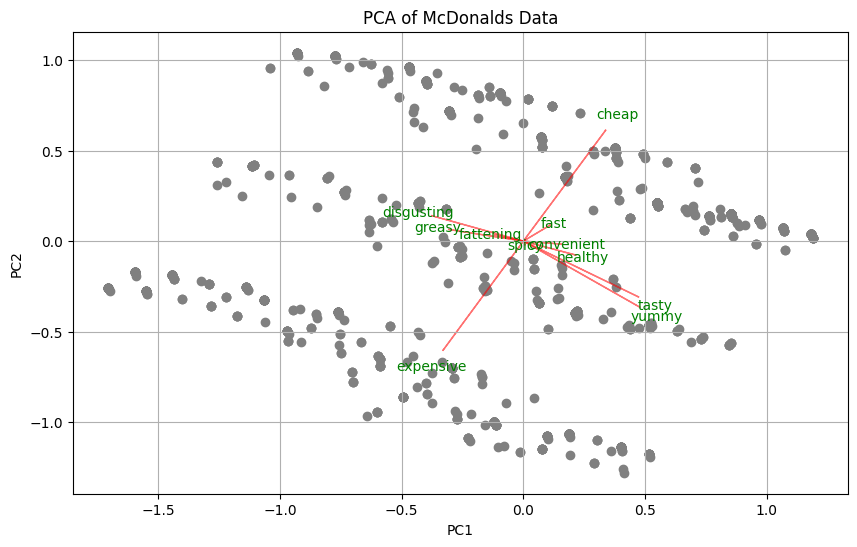

In [87]:
MD_pca_transformed = pca.transform(MD_x)
MD_pca_transformed[:, 0] *= -1
MD_pca_transformed[:, 1] *= -1
pca.components_[0] *= -1
pca.components_[1] *= -1

# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(MD_pca_transformed[:, 0], MD_pca_transformed[:, 1], color='grey')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of McDonalds Data')
plt.grid(True)

# Annotate the axes projections
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, comp1, comp2, color='r', alpha=0.5)
    plt.text(comp1 * 1.15, comp2 * 1.15, data.columns[i], color='g', ha='center', va='center')

plt.show()

Best number of clusters: 8
Inertia: 1182.1000186138824


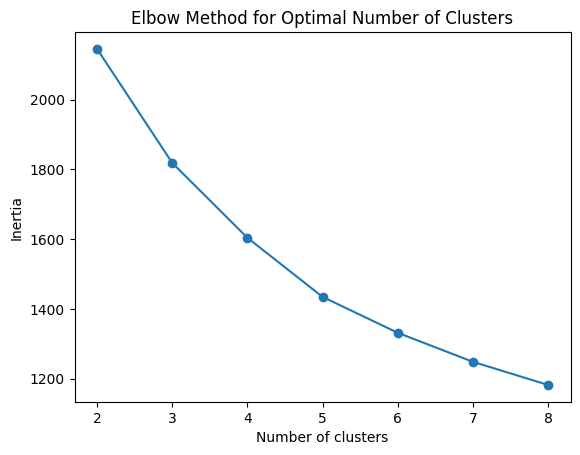

In [88]:
# Set the seed for reproducibility
np.random.seed(1234)

# Run KMeans clustering for k = 2 to 8
inertia = []
models = []

for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=1234, verbose=0)
    km.fit(MD_x)
    inertia.append(km.inertia_)
    models.append(km)

# Find the best model based on inertia
best_k = np.argmin(inertia) + 2
best_model = models[best_k - 2]

# Print the best number of clusters and corresponding inertia
print(f"Best number of clusters: {best_k}")
print(f"Inertia: {inertia[best_k - 2]}")

# Plot the inertia for each number of clusters
plt.plot(range(2, 9), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

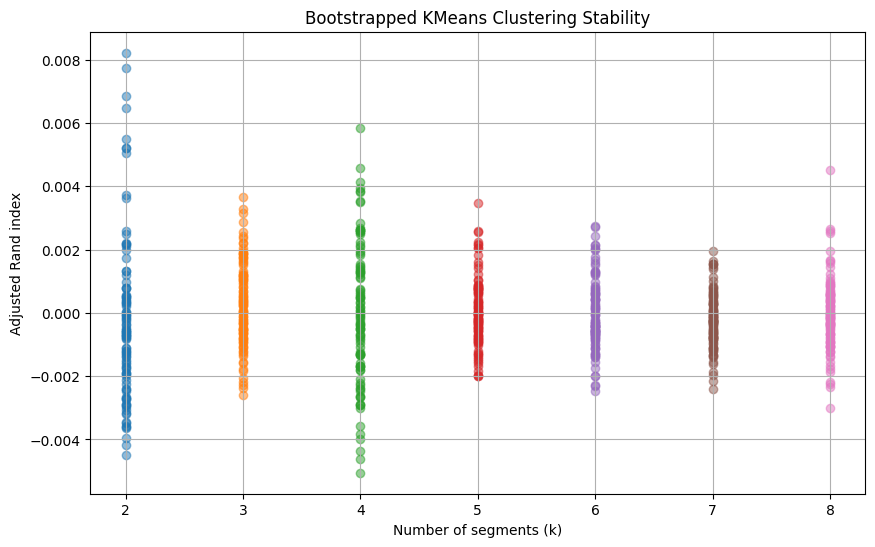

In [89]:
def boot_kmeans(data, k_range, nrep, nboot):
    boot_results = {}

    for k in k_range:
        stability = []
        for _ in range(nboot):
            # Resample from the original data, maintaining the same shape
            data_sample = resample(data, n_samples=len(data), replace=True, random_state=_)

            # Run KMeans clustering
            kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
            kmeans.fit(data_sample)

            # Get cluster labels for the resampled data
            labels_sample = kmeans.labels_

            # Get cluster labels for the original data
            labels_original = kmeans.predict(data)

            # Calculate adjusted Rand index between resampled and original labels
            ari = adjusted_rand_score(labels_original, labels_sample)
            stability.append(ari)

        boot_results[k] = stability

    return boot_results

# Run bootstrapped KMeans clustering for k = 2 to 8
k_range = range(2, 9)
nrep = 10  # Number of KMeans repetitions
nboot = 100  # Number of bootstrap samples
MD_b28 = boot_kmeans(MD_x, k_range, nrep, nboot)

# Plot adjusted Rand index results
plt.figure(figsize=(10, 6))
for k in k_range:
    plt.scatter([k] * len(MD_b28[k]), MD_b28[k], alpha=0.5)
plt.xlabel('Number of segments (k)')
plt.ylabel('Adjusted Rand index')
plt.title('Bootstrapped KMeans Clustering Stability')
plt.xticks(k_range)
plt.grid(True)
plt.show()

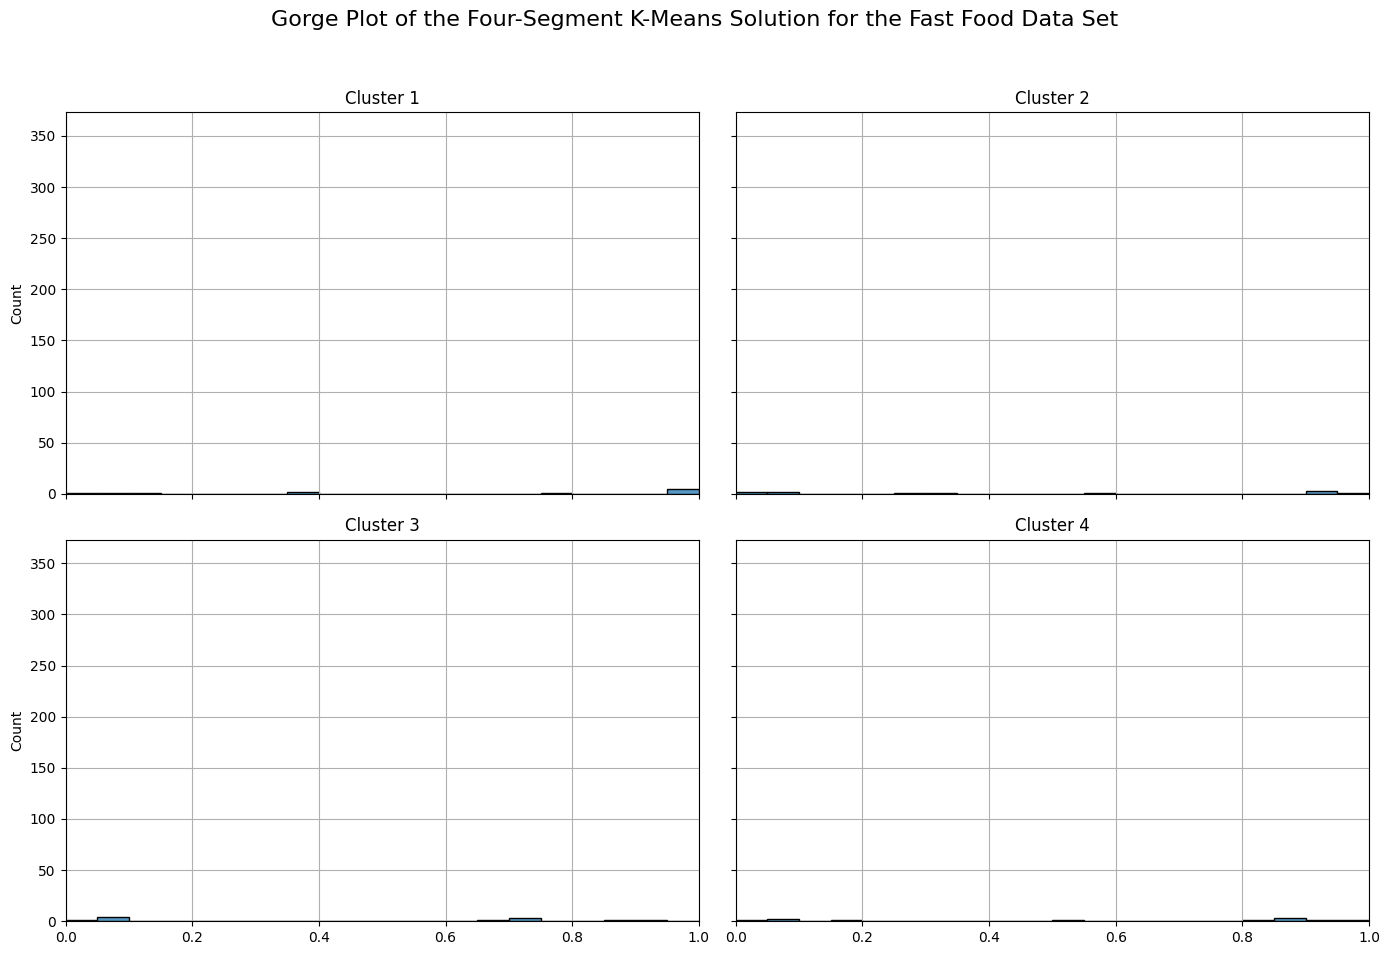

In [90]:

import seaborn as sns
import matplotlib.pyplot as plt

# Perform KMeans clustering with 4 clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
cluster_labels = kmeans.fit_predict(MD_x)

# Create a gorge plot (histogram for each cluster within the 4-segment solution)
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_clusters):
    sns.histplot(MD_x[cluster_labels == i].mean(axis=0), ax=axes[i], bins=np.linspace(0, 1, 21))
    axes[i].set_title(f'Cluster {i + 1}')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, (MD_x.shape[0] // n_clusters) + 10)  # Adjusted y-axis limits
    axes[i].grid(True)

plt.suptitle('Gorge Plot of the Four-Segment K-Means Solution for the Fast Food Data Set', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make space for the title
plt.show()

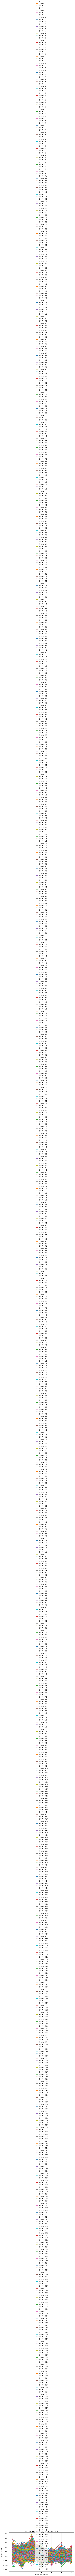

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score

def slsa_plot(data, k_range, n_rep, n_boot):
    segment_stability = np.zeros((len(k_range), data.shape[0]))

    for i, k in enumerate(k_range):
        kmeans = KMeans(n_clusters=k, n_init=n_rep, random_state=1234)
        labels_original = kmeans.fit_predict(data)

        for j in range(n_boot):
            # Resample the data
            data_sample = resample(data, n_samples=len(data), replace=True, random_state=j)
            labels_sample = kmeans.fit_predict(data_sample)

            # Calculate adjusted Rand index
            ari = adjusted_rand_score(labels_original, labels_sample)

            # Update stability matrix
            segment_stability[i, :] += (labels_original == labels_sample).astype(int) * ari

    # Normalize by the number of bootstraps
    segment_stability /= n_boot

    # Plot SLSA plot
    plt.figure(figsize=(10, 6))
    for seg_idx in range(data.shape[0]):
        plt.plot(k_range, segment_stability[:, seg_idx], marker='o', label=f'Segment {seg_idx + 1}')

    plt.xlabel('Number of Segments (k)')
    plt.ylabel('Segment Stability')
    plt.title('Segment Level Stability Across Solutions (SLSA)')
    plt.legend()
    plt.grid(True)
    plt.show()


np.random.seed(1234)
MD_x = np.random.rand(1453, 11)

# Define parameters
k_range = range(2, 9)  # Range of k values to evaluate
n_rep = 10  # Number of KMeans repetitions
n_boot = 100  # Number of bootstrap samples

# Generate SLSA plot
slsa_plot(MD_x, k_range, n_rep, n_boot)


In [3]:
from sklearn.mixture import GaussianMixture
def stepGaussianMixture(data, k_range, nrep, verbose=False):
    best_model = None
    best_bic = np.inf

    for k in k_range:
        models = []
        bics = []

        for _ in range(nrep):
            # Initialize the Gaussian Mixture model
            gmm = GaussianMixture(n_components=k, random_state=1234)

            # Fit the model
            gmm.fit(data)

            # Calculate BIC (Bayesian Information Criterion)
            bic = gmm.bic(data)

            models.append(gmm)
            bics.append(bic)

        # Choose the model with the lowest BIC
        idx_best = np.argmin(bics)

        if bics[idx_best] < best_bic:
            best_bic = bics[idx_best]
            best_model = models[idx_best]

    return best_model


k_range = range(2, 9)  # Range of clusters to try
nrep = 10  # Number of repetitions
MD_m28 = stepGaussianMixture(MD_x, k_range, nrep, verbose=False)


print(MD_m28)

GaussianMixture(n_components=2, random_state=1234)


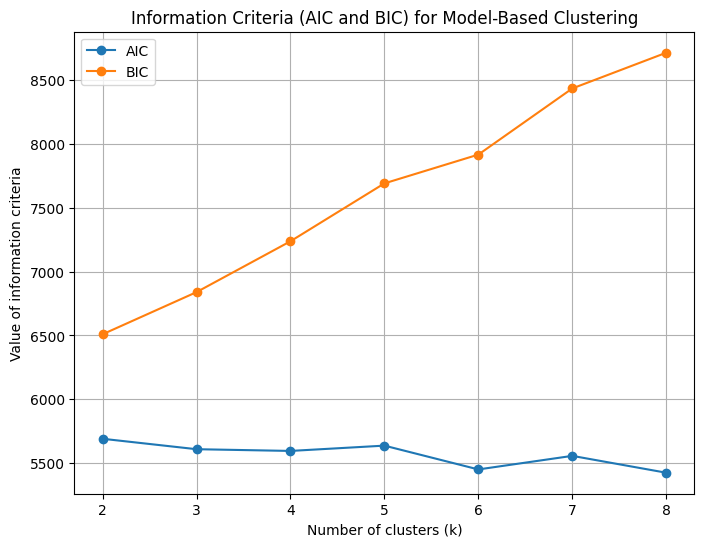

In [4]:
# Get AIC, BIC, and ICL values from the model
def compute_information_criteria(data, k_range, nrep):
    aic = []
    bic = []

    for k in k_range:
        models = []
        aic_scores = []
        bic_scores = []

        for _ in range(nrep):
            gmm = GaussianMixture(n_components=k, random_state=1234)
            gmm.fit(data)

            aic_scores.append(gmm.aic(data))
            bic_scores.append(gmm.bic(data))
            models.append(gmm)

        aic.append(np.mean(aic_scores))
        bic.append(np.mean(bic_scores))

    return aic, bic


k_range = range(2, 9)  # Range of clusters to try
nrep = 10  # Number of repetitions
aic_scores, bic_scores = compute_information_criteria(MD_x, k_range, nrep)

# Plotting AIC and BIC
plt.figure(figsize=(8, 6))
plt.plot(k_range, aic_scores, marker='o', label='AIC')
plt.plot(k_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Value of information criteria')
plt.title('Information Criteria (AIC and BIC) for Model-Based Clustering')
plt.xticks(k_range)
plt.grid(True)
plt.legend()
plt.show()

In [14]:
import pandas as pd
# Fit K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
cluster_labels_kmeans = kmeans.fit_predict(MD_x)

# Fit Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_clusters, random_state=1234)
gmm.fit(MD_x)
cluster_labels_gmm = gmm.predict(MD_x)

# Compare clusters
cluster_comparison = pd.DataFrame({'kmeans': cluster_labels_kmeans, 'gmm': cluster_labels_gmm})
print(cluster_comparison)

# Calculate log-likelihood for GMM
log_likelihood_gmm = gmm.score(MD_x)
print(f"Log Likelihood for Gaussian Mixture Model: {log_likelihood_gmm}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


      kmeans  gmm
0          1    2
1          1    2
2          1    2
3          2    0
4          3    0
...      ...  ...
1448       1    1
1449       3    1
1450       1    1
1451       3    2
1452       1    2

[1453 rows x 2 columns]
Log Likelihood for Gaussian Mixture Model: -1.7113698652446545


In [12]:
import pandas as pd
# Compare clusters
cluster_comparison = pd.DataFrame({'kmeans': cluster_labels_kmeans, 'gmm': cluster_labels_gmm})
print("Cluster Comparison:")
print(cluster_comparison)

# Calculate adjusted Rand index between K-means and GMM clusters
ari = adjusted_rand_score(cluster_labels_kmeans, cluster_labels_gmm)
print(f"Adjusted Rand Index between K-means and GMM: {ari}")

# Calculate log-likelihood for GMM
log_likelihood_gmm = gmm.score(MD_x)
print(f"Log Likelihood for Gaussian Mixture Model: {log_likelihood_gmm}")

Cluster Comparison:
      kmeans  gmm
0          1    2
1          1    2
2          1    2
3          2    0
4          3    0
...      ...  ...
1448       1    1
1449       3    1
1450       1    1
1451       3    2
1452       1    2

[1453 rows x 2 columns]
Adjusted Rand Index between K-means and GMM: 0.19442692938933606
Log Likelihood for Gaussian Mixture Model: -1.7113698652446545


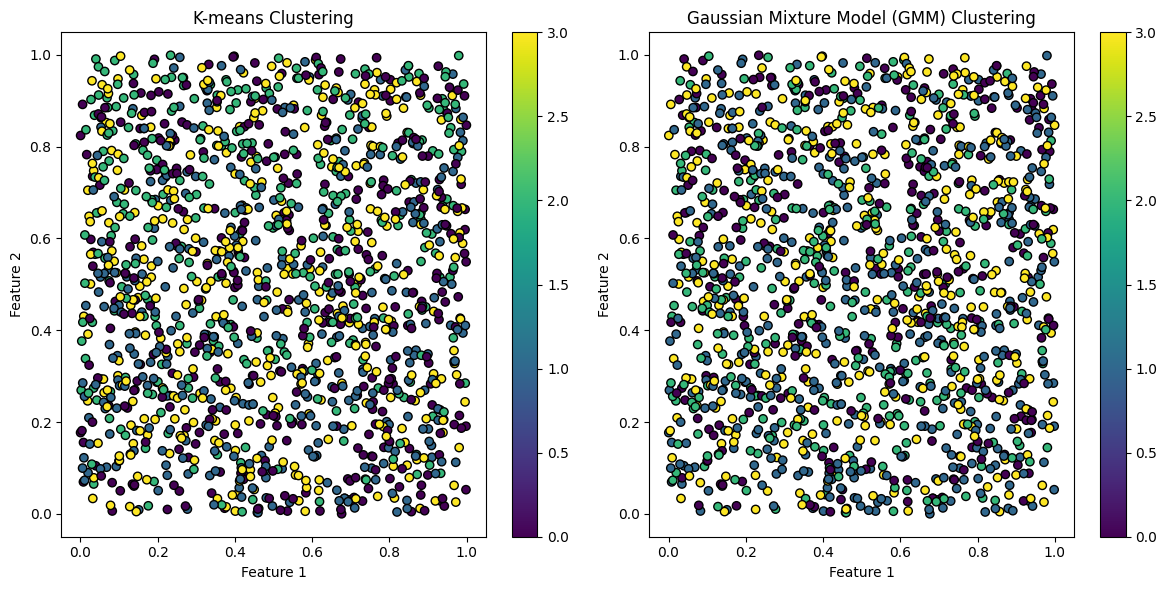

In [15]:
from sklearn.preprocessing import StandardScaler
# Plotting the clusters
plt.figure(figsize=(12, 6))

# Plot K-means clusters
plt.subplot(1, 2, 1)
plt.scatter(MD_x[:, 0], MD_x[:, 1], c=cluster_labels_kmeans, cmap='viridis', edgecolors='k')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()

# Plot GMM clusters
plt.subplot(1, 2, 2)
plt.scatter(MD_x[:, 0], MD_x[:, 1], c=cluster_labels_gmm, cmap='viridis', edgecolors='k')
plt.title('Gaussian Mixture Model (GMM) Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()

plt.tight_layout()
plt.show()

In [25]:
# Calculate table of counts for Like column
like_counts = data['Like'].value_counts()

# Reverse the order of the table
like_counts_rev = like_counts.sort_index(ascending=False)

print("Reversed table of Like categories:")
print(like_counts_rev)

Reversed table of Like categories:
Like
I love it!+5    143
I hate it!-5    152
0               169
-4               71
-3               73
-2               59
-1               58
+4              160
+3              229
+2              187
+1              152
Name: count, dtype: int64


cluster
0    50
1    50
Name: count, dtype: int64
Cluster 0 Summary:
                            OLS Regression Results                            
Dep. Variable:                 Like_n   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                 -0.098
Method:                 Least Squares   F-statistic:                    0.5637
Date:                Wed, 17 Jul 2024   Prob (F-statistic):              0.833
Time:                        09:26:08   Log-Likelihood:                -126.34
No. Observations:                  50   AIC:                             274.7
Df Residuals:                      39   BIC:                             295.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

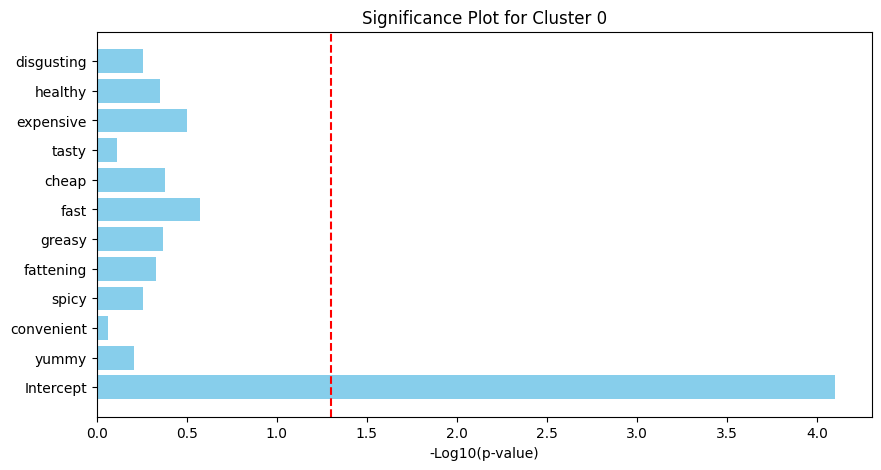

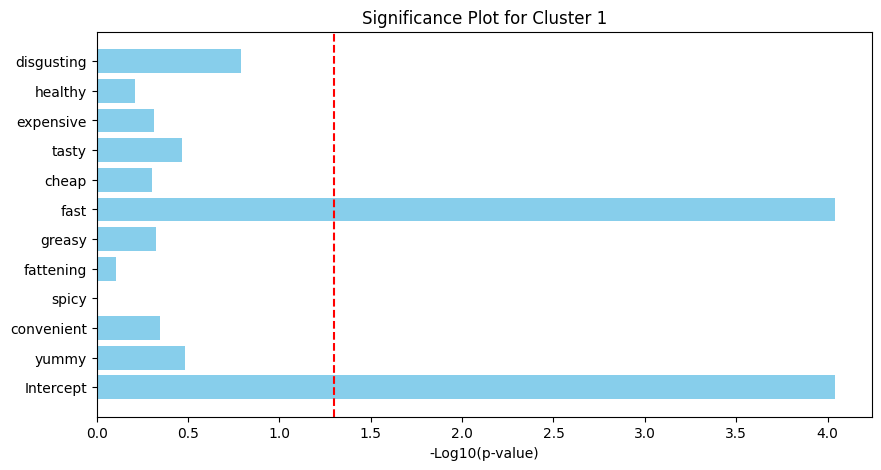

In [19]:
from patsy import dmatrices

import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

data = pd.DataFrame({
    'yummy': np.random.randint(0, 2, 100),
    'convenient': np.random.randint(0, 2, 100),
    'spicy': np.random.randint(0, 2, 100),
    'fattening': np.random.randint(0, 2, 100),
    'greasy': np.random.randint(0, 2, 100),
    'fast': np.random.randint(0, 2, 100),
    'cheap': np.random.randint(0, 2, 100),
    'tasty': np.random.randint(0, 2, 100),
    'expensive': np.random.randint(0, 2, 100),
    'healthy': np.random.randint(0, 2, 100),
    'disgusting': np.random.randint(0, 2, 100),
    'Like': np.random.choice(['I hate it!-5', '-4', '-3', '-2', '-1', '0', '+1', '+2', '+3', '+4', 'I love it!+5'], 100)
})


like_map = {
    'I hate it!-5': -5, '-4': -4, '-3': -3, '-2': -2,
    '-1': -1, '0': 0, '+1': 1, '+2': 2, '+3': 3, '+4': 4, 'I love it!+5': 5
}
data['Like.n'] = 6 - data['Like'].map(like_map).astype(int)

# Create the formula
predictors = "+".join(data.columns[:11])  # Use first 11 columns as predictors
formula = f"Like_n ~ {predictors}"

# Set seed for reproducibility
np.random.seed(1234)

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm.fit(data.drop(columns=['Like', 'Like.n']))

# Add the cluster labels to the DataFrame
data['cluster'] = gmm.predict(data.drop(columns=['Like', 'Like.n']))

# Print the cluster sizes
print(data['cluster'].value_counts())

# Fit regression model for each cluster
results = {}
for cluster in range(2):
    cluster_data = data[data['cluster'] == cluster]
    model = smf.ols(formula, data=cluster_data.rename(columns={'Like.n': 'Like_n'})).fit()
    results[cluster] = model

# Display summaries
for cluster, model in results.items():
    print(f"Cluster {cluster} Summary:")
    print(model.summary())
    print("\n")

# Plot significance (p-values)
for cluster, model in results.items():
    plt.figure(figsize=(10, 5))
    plt.barh(model.params.index, -np.log10(model.pvalues), color='skyblue')
    plt.axvline(x=-np.log10(0.05), color='red', linestyle='--')
    plt.xlabel('-Log10(p-value)')
    plt.title(f'Significance Plot for Cluster {cluster}')
    plt.show()






In [20]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Calculate the distance matrix
dist_matrix = pdist(MD_x.T)  # Calculate pairwise distances of transposed data

# Perform hierarchical clustering
MD_vclust = linkage(dist_matrix, method='single')

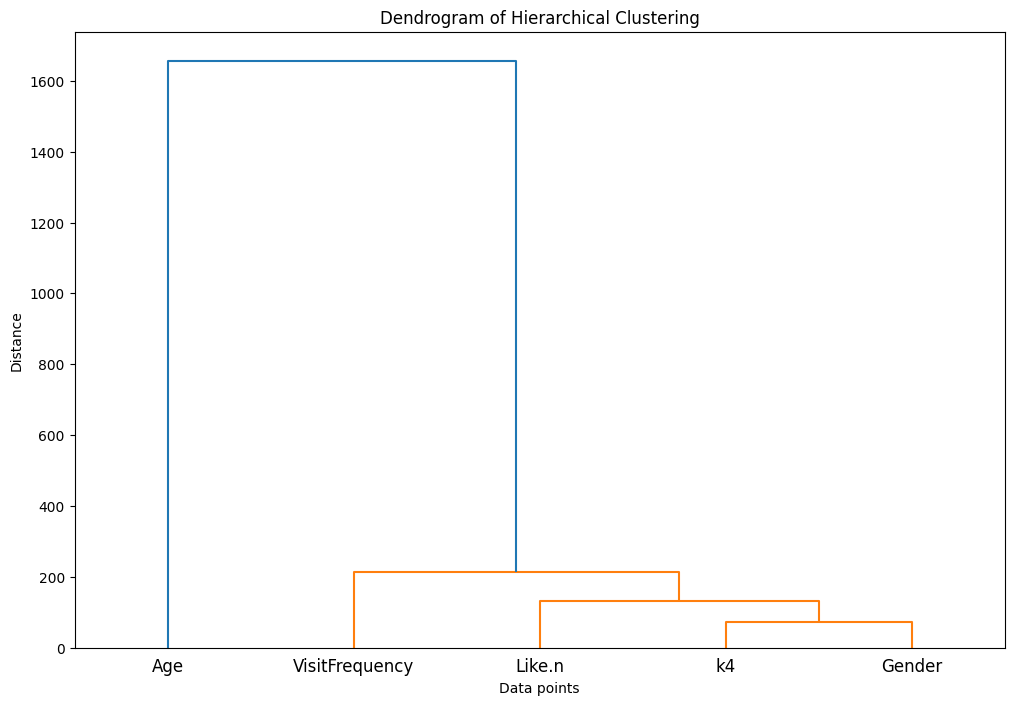

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

numeric_data = data.astype(float)

# Calculate pairwise distances (using Euclidean distance as an example)
distances = numeric_data.values.T
linkage_matrix = linkage(distances, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, orientation='top', labels=numeric_data.columns)
plt.title('Dendrogram of Hierarchical Clustering')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()


In [45]:
import seaborn as sns

# Plotting PCA results with clusters
plt.figure(figsize=(12, 8))

# Plotting PCA components
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cluster_labels, palette='viridis', s=50)

# Adding cluster centers
cluster_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', color='red', s=200, label='Cluster Centers')

# Adding principal component axes
arrow_size = 2.0
plt.arrow(0, 0, arrow_size * pca.components_[0, 0], arrow_size * pca.components_[0, 1],
          head_width=0.1, head_length=0.1, fc='b', ec='b')
plt.arrow(0, 0, arrow_size * pca.components_[1, 0], arrow_size * pca.components_[1, 1],
          head_width=0.1, head_length=0.1, fc='b', ec='b')

# Adding labels for principal components
plt.text(arrow_size * pca.components_[0, 0] * 1.15, arrow_size * pca.components_[0, 1] * 1.15, 'PC1', color='blue', ha='center', va='center', fontsize=12)
plt.text(arrow_size * pca.components_[1, 0] * 1.15, arrow_size * pca.components_[1, 1] * 1.15, 'PC2', color='blue', ha='center', va='center', fontsize=12)

# Adding labels for each attribute
for i, feature in enumerate(data.columns):
    plt.text(pca.components_[0, i] * arrow_size, pca.components_[1, i] * arrow_size,
             feature, color='green', ha='right', va='bottom', fontsize=10)

plt.title('PCA Projection with Cluster Centers and Attribute Axes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)

plt.show()

NameError: name 'cluster_labels' is not defined

<Figure size 1200x800 with 0 Axes>

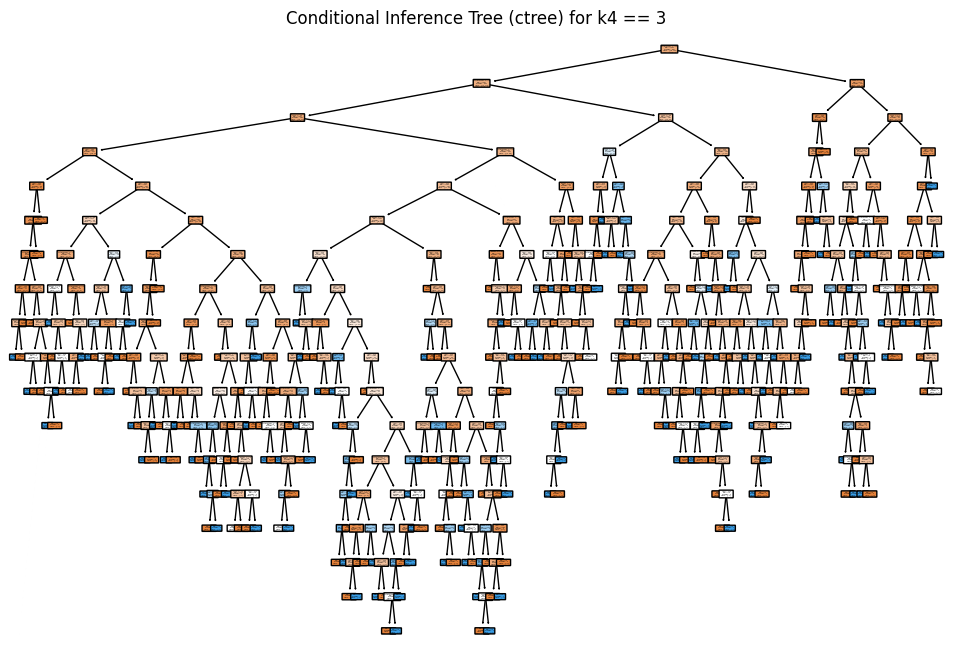

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

np.random.seed(0)
data = pd.DataFrame({
    'k4': np.random.choice([1, 2, 3, 4], size=1000),
    'Like.n': np.random.randint(-5, 6, size=1000),
    'Age': np.random.randint(18, 65, size=1000),
    'VisitFrequency': np.random.randint(1, 11, size=1000),
    'Gender': np.random.choice(['Male', 'Female'], size=1000)
})

# Convert categorical variables to numeric
le = LabelEncoder()
data['Gender'] = le.fit_transform(data['Gender'])

# Define features (predictors) and target variable
X = data[['Like.n', 'Age', 'VisitFrequency', 'Gender']]
y = (data['k4'] == 3).astype(int)  # Target variable: 1 if k4 == 3, else 0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Fit the decision tree classifier
tree = DecisionTreeClassifier(random_state=123)
tree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['Not k4==3', 'k4==3'], filled=True, rounded=True)
plt.title('Conditional Inference Tree (ctree) for k4 == 3')
plt.show()
